<a href="https://colab.research.google.com/github/urvashiramdasani/ML-DL-Python/blob/master/DL/Semantic_Segmentation_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Urvashi Ramdasani

Roll Number : 18BCE247

Aim : Semantic Segmentation using VGG16 Autoencoder

In [1]:
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU

Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /content/dataset1.zip
126MB [00:00, 154MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('/content/dataset1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
import numpy as np
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, UpSampling2D, Lambda
from keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size = 2
epochs = 5
classes = 12

In [5]:
def unet_with_vgg_encoder():
  pretrained_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (360, 480, 3))
  pretrained_model.summary()

  input_layer = pretrained_model.input
  output_layer_pretrained = pretrained_model.layers[-6].output

  encoder = Model(input_layer, output_layer_pretrained)
  for i in encoder.layers:
    i.trainable = False

  encoder.summary()

  lastPooling = MaxPooling2D(pool_size = (2, 2), padding = 'same')(output_layer_pretrained)
  center = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(lastPooling)
  center = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(center)
  center = BatchNormalization()(center)

  up4 = UpSampling2D((2, 2))(center)
  up4 = Conv2D(512, (2, 2), activation = 'relu', padding = 'same')(up4)
  up4 = Lambda(lambda x: x[:, 0:45, :, :])(up4)
  up4 = concatenate([up4, encoder.get_layer('block4_conv3').output], axis = 3)
  up4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(up4)
  up4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(up4)
  up4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(up4)
  up4 = BatchNormalization()(up4)

  up3 = UpSampling2D((2, 2))(up4)
  up3 = Conv2D(256, (2, 2), activation = 'relu', padding = 'same')(up3)
  up3 = concatenate([up3, encoder.get_layer('block3_conv3').output], axis = 3)
  up3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up3)
  up3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up3)
  up3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up3)
  up3 = BatchNormalization()(up3)

  up2 = UpSampling2D((2, 2))(up3)
  up2 = Conv2D(128, (2, 2), activation = 'relu', padding = 'same')(up2)
  up2 = concatenate([up2, encoder.get_layer('block2_conv2').output], axis = 3)
  up2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up2)
  up2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up2)
  up2 = BatchNormalization()(up2)

  up1 = UpSampling2D((2, 2))(up2)
  up1 = Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(up1)
  up1 = concatenate([up1, encoder.get_layer('block1_conv2').output], axis = 3)
  up1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up1)
  up1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up1)
  up1 = Conv2D(classes, (1, 1), activation = 'softmax', padding = 'same')(up1)

  model = Model(input_layer, up1)
  model.summary()
  return model

In [6]:
def traingenerator():
  image_datagen = ImageDataGenerator(rescale = 1 / 255)
  mask_datagen = ImageDataGenerator()

  image_batch_generator = image_datagen.flow_from_directory(
      directory = '/content/dataset1/train', class_mode = None, target_size = (360, 480),
      shuffle = False, seed = 2019, batch_size = batch_size, color_mode = 'rgb'
  )

  mask_batch_generator = mask_datagen.flow_from_directory(
      directory = '/content/dataset1/annotations', class_mode = None, target_size = (360, 480),
      shuffle = False, seed = 2019, batch_size = batch_size, color_mode = 'grayscale'
  )

  combined_generator = zip(image_batch_generator, mask_batch_generator)

  for (i, j) in combined_generator:
    new_mask = np.zeros(shape = (j.shape[0], j.shape[1], j.shape[2], classes))
    for k in range(j.shape[0]):
      mask = j[k]
      for m in range(classes):
        new_mask[k, :, :, m] = mask[:, :, 0] == m
    yield(i, new_mask)

In [7]:
def testgenerator():
  image_test_datagen = ImageDataGenerator(rescale = 1 / 255)

  image_test_generator = image_test_datagen.flow_from_directory(
      directory = '/content/dataset1/test', class_mode = None, target_size = (360, 480),
      shuffle = False, seed = 2019, batch_size = batch_size, color_mode = 'rgb'
  )

  for i in image_test_generator:
    yield i

In [8]:
unet = unet_with_vgg_encoder()
unet.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
______________________________________________________________

In [9]:
unet.fit(traingenerator(), steps_per_epoch = 400, epochs = epochs)

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Epoch 1/5
400/400 [==============================] - 208s 413ms/step - loss: 1.1130 - accuracy: 0.6503
Epoch 2/5
400/400 [==============================] - 160s 400ms/step - loss: 0.7172 - accuracy: 0.7756
Epoch 3/5
400/400 [==============================] - 160s 401ms/step - loss: 0.5801 - accuracy: 0.8225
Epoch 4/5
400/400 [==============================] - 161s 402ms/step - loss: 0.4575 - accuracy: 0.8615
Epoch 5/5
400/400 [==============================] - 161s 402ms/step - loss: 0.4026 - accuracy: 0.8744


In [10]:
results = unet.predict(testgenerator(), steps = 51)

Found 101 images belonging to 1 classes.


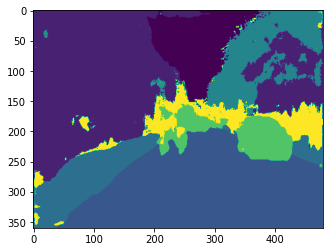

In [11]:
import matplotlib.pyplot as plt

img1 = np.argmax(results[0, :, :, :], axis = 2)
img1 = np.reshape(img1, (360, 480))
plt.imshow(img1)
plt.show()